In [1]:
import sys

sys.path.append("../")



from benchmarks.inference_models import Brownian
from benchmarks.sampling_algorithms import adjusted_mclmc_tuning, nuts
from blackjax.diagnostics import effective_sample_size
from collections import defaultdict
from functools import partial
import math
import operator
import os
import pprint
from statistics import mean, median
import jax
import jax.numpy as jnp
import pandas as pd
import scipy
from jax.flatten_util import ravel_pytree
from benchmarks.benchmark import benchmark
from benchmarks.sampling_algorithms import unadjusted_mclmc
from benchmarks.inference_models import Gaussian, Brownian, GermanCredit
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
import blackjax 

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(128)
num_cores = jax.local_device_count()

# model = StandardNormal(10)
# model = IllConditionedGaussian(100, 12916)

def benchmark(model, num_steps, num_chains=128):

    results = defaultdict(tuple)


    integrator_type = "mclachlan"

    preconditioning = False


    init_key, mclmc_key, nuts_key = jax.random.split(jax.random.PRNGKey(2), 3)
    initial_position = model.sample_init(init_key)
    

   
    ess, ess_avg, ess_corr, params, acceptance_rate, grads_to_low_avg, err_t_mean_avg_mclmc, err_t_mean_max_mclmc = benchmark(
                model,
                unadjusted_mclmc(integrator_type=integrator_type, preconditioning=preconditioning),
                mclmc_key,
                n=num_steps,
                batch=num_chains,
    )

    

    results[
                        (
                            model.name,
                            model.ndims,
                            f"mclmc",
                            jnp.nanmean(params.L).item(),
                            jnp.nanmean(params.step_size).item(),
                            integrator_type,
                            f"abla",
                            acceptance_rate.mean().item(),
                            False,
                            0,
                            ess_avg,
                            ess_corr.mean().item(),
                            ess_corr.min().item(),
                            (1/(1/ess_corr).mean()).item(),
                            num_steps,
                            True,
                            1,
                        )
                    ] = ess
    
    ess, ess_avg, ess_corr, params, acceptance_rate, grads_to_low_avg, err_t_mean_avg_nuts, err_t_mean_max_nuts = benchmark(
                    model,
                    nuts(integrator_type="velocity_verlet", preconditioning=preconditioning),
                    nuts_key,
                    n=num_steps,
                    batch=num_chains,
                )
                
    results[
        (
            model.name,
            model.ndims,
            "nuts",
            0.0,
            0.0,
            "velocity_verlet",
            "standard",
            acceptance_rate.mean().item(),
            preconditioning,
            0,
            ess_avg,
            ess_corr.mean().item(),
            ess_corr.min().item(), (1/(1/ess_corr).mean()).item(),
            num_steps,
            None,
            -1,
        )
    ] = ess
    
    df = pd.Series(results).reset_index()
    df.columns = [
            "model", "dims", "sampler", "L", "step_size", "integrator", "tuning", "acc_rate", "preconditioning", "inv_L_prop", "ess_avg", "ess_corr_avg", "ess_corr_min", "ess_corr_inv_mean", "num_steps", "worst", "num_windows", "ESS"]
    return df, err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts

In [3]:
def plot_bias(model, num_steps):

    df, err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts = benchmark(model, num_steps=num_steps)

    df_err = pd.DataFrame({'err_t_mean_avg_mclmc': err_t_mean_avg_mclmc[2000:]})
    # df_err['sampler'] = 'mclmc'
    df_err['err_t_mean_avg_nuts'] = err_t_mean_avg_nuts[2000:]
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_avg_mclmc', label='mclmc')
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_avg_nuts', label='nuts')
    plt.title(f"Model: {model.name}")
    plt.show()

    df_err = pd.DataFrame({'err_t_mean_max_mclmc': err_t_mean_max_mclmc[200:]})
    # df_err['sampler'] = 'mclmc'
    df_err['err_t_mean_max_nuts'] = err_t_mean_max_nuts[200:]
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_max_mclmc', label='mclmc')
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_max_nuts', label='nuts')
    plt.title(f"Model: {model.name}")
    plt.show()



In [4]:
plot_bias(Gaussian(1000), num_steps=10000)
# plot_bias(Gaussian(10))
# plot_bias(GermanCredit())
# plot_bias(Gaussian(1000))

<Axes: xlabel='sampler', ylabel='ESS'>

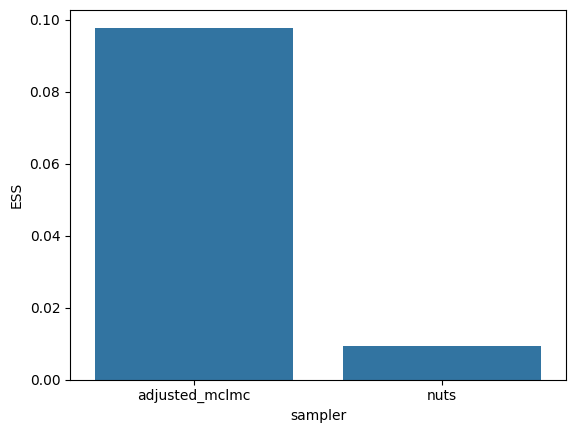

In [17]:

sns.barplot(data=df, x="sampler", y="ESS")

In [8]:
from benchmarks.inference_models import Funnel


df, err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts = benchmark(Funnel(), num_steps=10000)

def plot_bias(model, err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts):


    df_err = pd.DataFrame({'err_t_mean_avg_mclmc': err_t_mean_avg_mclmc[2000:]})
    # df_err['sampler'] = 'mclmc'
    df_err['err_t_mean_avg_nuts'] = err_t_mean_avg_nuts[2000:]
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_avg_mclmc', label='mclmc')
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_avg_nuts', label='nuts')
    plt.title(f"Model: {model.name}")
    plt.show()

    df_err = pd.DataFrame({'err_t_mean_max_mclmc': err_t_mean_max_mclmc[2000:]})
    # df_err['sampler'] = 'mclmc'
    df_err['err_t_mean_max_nuts'] = err_t_mean_max_nuts[2000:]
    # df_err_nuts['sampler'] = 'nuts'
    # df = pd.concat([df_err_mclmc, df_err_nuts])
    df_err
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_max_mclmc', label='mclmc')
    sns.lineplot(data=df_err, x=df_err.index, y='err_t_mean_max_nuts', label='nuts')
    plt.title(f"Model: {model.name}")
    plt.show()

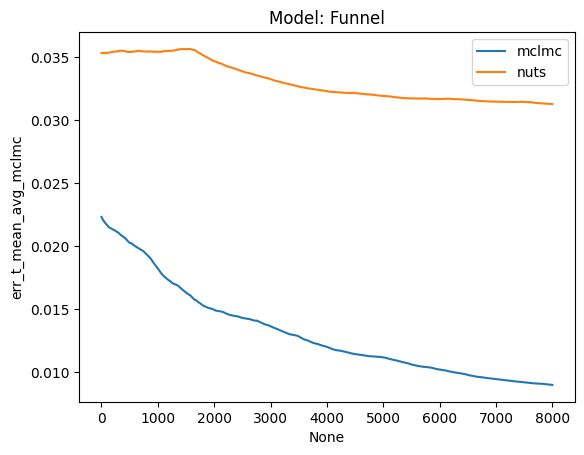

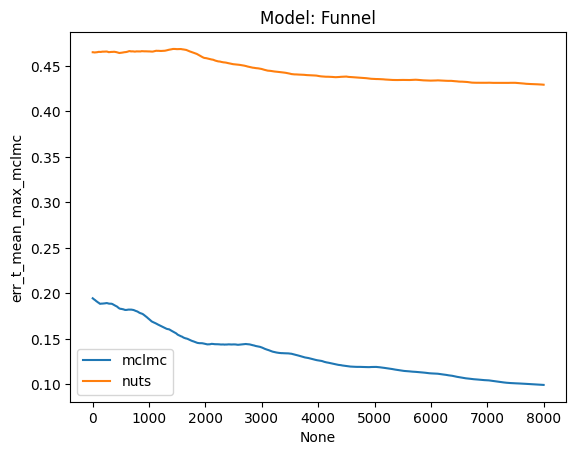

In [9]:
plot_bias(Funnel(), err_t_mean_avg_mclmc, err_t_mean_max_mclmc, err_t_mean_avg_nuts, err_t_mean_max_nuts)